# Edit Railways and view graphs


In [1]:
from collections import OrderedDict
from flatland.envs.observations import TreeObsForRailEnv
from flatland.envs.rail_env import RailEnv
from flatland.utils.rendertools import RenderTool
from PIL import Image
import networkx as nx
import json
from numpy import array
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from ipywidgets import Button, HBox, VBox
from flatland.utils.graph_utils import RailEnvGraph, trans_int_to_4x4, trans_int_to_binstr, trans_int_to_nesw, get_rail_transitions_df
from flatland.utils.graph_utils import get_simple_path, plotGraphEnv
import flatland.utils.graph_utils as gu
from flatland.envs.rail_generators import rail_from_manual_specifications_generator
from flatland.envs.rail_generators import random_rail_generator, complex_rail_generator, sparse_rail_generator, empty_rail_generator
from flatland.utils.editor import EditorMVC
display(HTML("<style>.container { width:90% !important; }</style>"))

Flask static folder:  /home/jeremy/projects/aicrowd/rl-trains/flatland/notebooks/static


In [2]:
from flatland.utils.editor import EditorMVC

In [3]:
mvc = EditorMVC(sGL="PILSVG" ) 

/home/jeremy/projects/aicrowd/rl-trains/flatland/flatland/utils/rendertools.py:450: UserWarning: Predictor did not provide any predicted cells to render.                 Observation builder needs to populate: env.dev_obs_dict
  Observation builder needs to populate: env.dev_obs_dict")


## Instructions
- Drag to draw (improved dead-ends)
- ctrl-click to add agent or select agent
  - if agent is selected:
    - ctrl-click to move agent position
    - use rotate agent to rotate 90° 
    - ctrl-shift-click to set target for selected agent 
      - target can be moved by repeating
- to Resize the env (cannot preserve work):
  - select "Regen" tab, set regen size slider, click regenerate.
- alt-click remove all rails from cell 


Demo Scene: complex_scene.pkl


In [14]:
env = RailEnv(width=20, height=20, rail_generator=empty_rail_generator(), number_of_agents=0,
                          obs_builder_object=TreeObsForRailEnv(max_depth=2))
mvc = EditorMVC(sGL="PILSVG", env=env ) 

In [15]:
mvc.view.display()

agent targ: (13, 15) computed:  []
agent targ: (13, 6) computed:  [(13, 15)]
agent targ: (5, 6) computed:  [(13, 15), (13, 6)]


In [45]:
# Run this cell if you would like to see debug output
mvc.view.output_generator.clear_output()
mvc.view.output_generator

Output(outputs=({'output_type': 'stream', 'text': 'Regenerate size 20 20\nsave to  loop.pkl  working dir:  /ho…

In [46]:
display(mvc.view.debug)
display(mvc.view.debug_move)

Checkbox(value=False, description='Debug')

Checkbox(value=False, description='Debug mouse move')

In [47]:
env = mvc.editor.env

In [48]:
gEnv = RailEnvGraph(env)
G = gEnv.G
[ (n,d) for n, d in G.nodes(data=True) if "type" not in d ]

[]

In [49]:
mvc.view.oRT.render_env(show_agents=True)
aImg = mvc.view.oRT.get_image()

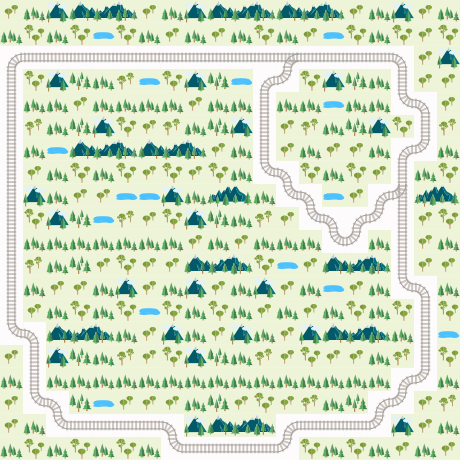

In [50]:
Image.fromarray(aImg)

In [51]:
G2 = gEnv.graph_rail_grid()

In [52]:
G = gEnv.G

In [53]:
[ (n,d) for n, d in G.nodes(data=True) if "type" not in d ]

[]

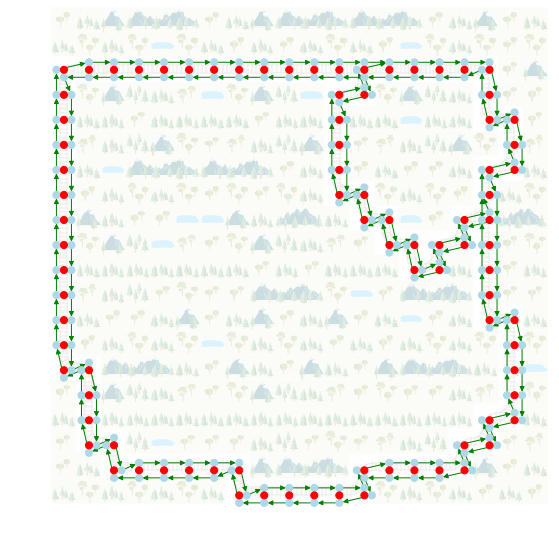

In [54]:
plotGraphEnv(G2, env, aImg, node_size=50, alpha_img=0.2, figsize=(10,10))

In [55]:
G5 = gEnv.reduce_simple_paths()

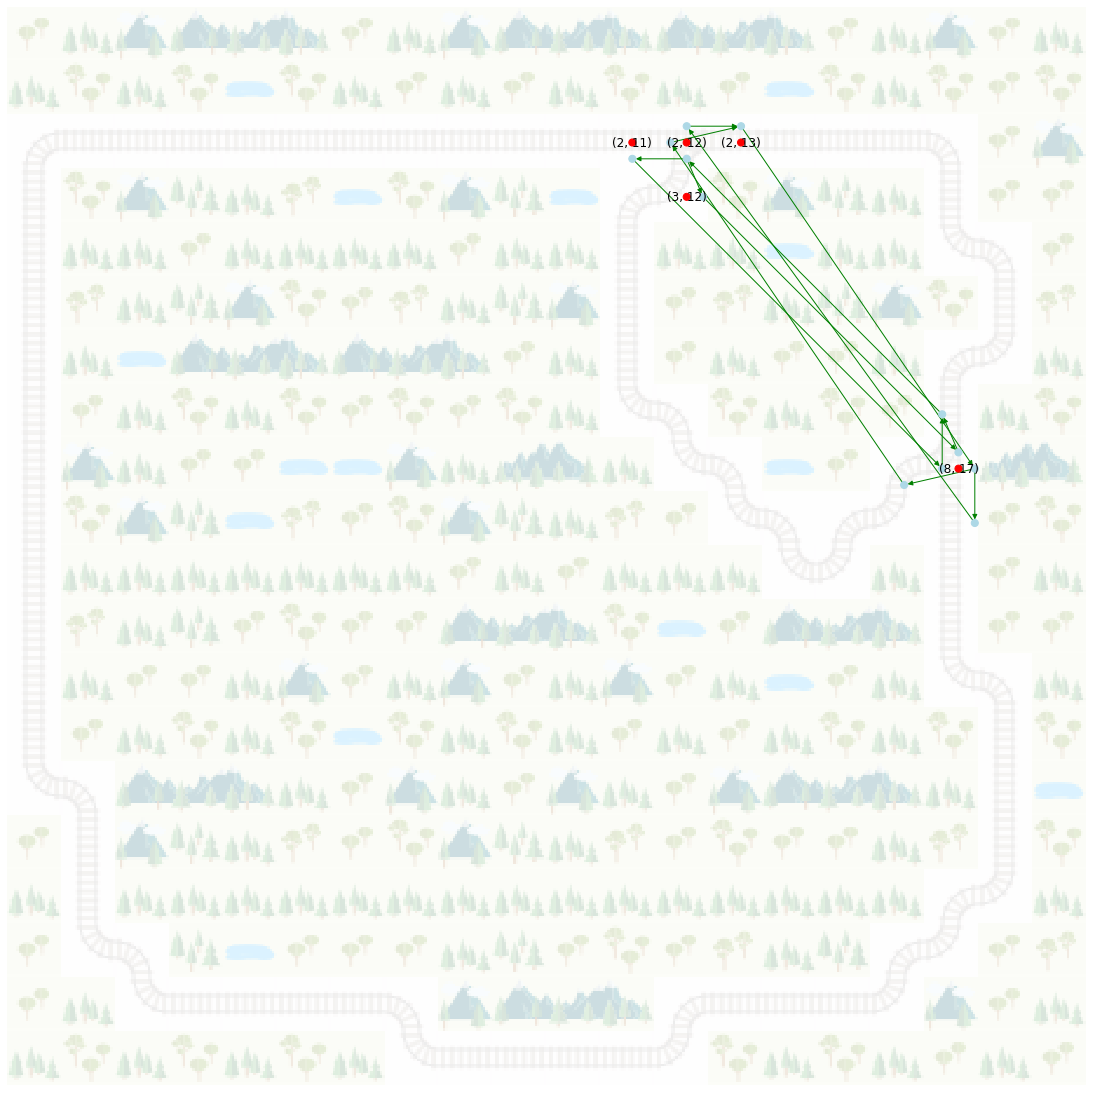

In [56]:
plotGraphEnv(G5, env, aImg, node_size=50, alpha_img=0.2, figsize=(20,20), show_labels=("grid"))

In [57]:
gEnv.savejson(filename="g2.json", alt_graph=G5)

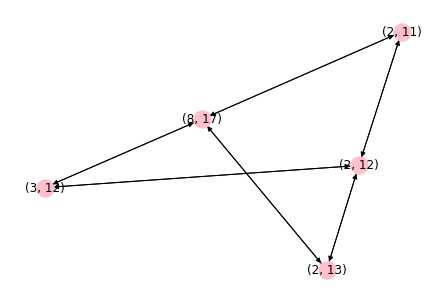

In [58]:
G5b = nx.induced_subgraph(G5, [ n for n, d in G5.nodes(data=True) if d["type"]=="grid" ])
gEnv.savejson(filename="test_edit_2.json", alt_graph=G5b)
nx.draw(G5b, with_labels=True, node_color="pink")